In [1]:
import numpy as np
import os
import pandas as pd
from pathlib import Path
import scipy.io
import h5py
import sklearn
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import scipy.stats as stats
from scipy.stats import ttest_ind, mannwhitneyu

# **Load data and reconstruct matrices**

In [2]:
data_raw = pd.read_csv('data_raw_nmm_new.csv')
data_harm = pd.read_csv('data_harm_nmm_new.csv')
roi_data_harm = pd.read_csv('roi_data_harm_nmm_new.csv')
strat_covars = pd.read_csv('MatchedData01.csv')

In [3]:
#reconstruct the matrices from harmonized data

n_matrices, upper_triangle_size = data_harm.shape
N = int((1 + np.sqrt(1 + 8 * upper_triangle_size)) // 2)
matrices_harm = np.zeros((n_matrices, N, N))

for i in range(n_matrices):
  matrix = np.eye(N)
  upper_indices = np.triu_indices(N, k=1)
  matrix[upper_indices] = data_harm.iloc[i]
  matrix = matrix + matrix.T
  np.fill_diagonal(matrix, 1)
  matrices_harm[i] = matrix

In [4]:
# Create adjacency matrices from harmonized data
adjacency_matrices = np.zeros_like(matrices_harm, dtype=int)
for i in range(matrices_harm.shape[0]):
  threshold = np.percentile(matrices_harm[i], 70)
  adjacency_matrices[i] = (matrices_harm[i] >= threshold).astype(int)

In [5]:
#Create masked matrices
masked_matrices_harm = matrices_harm * adjacency_matrices

# **PyTorch Geometric**

In [9]:
import torch
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader
import os


In [11]:
class MindDataset(InMemoryDataset):
    def __init__(self, root, matrices_harm, strat_covars, adjacency_matrices, roi_data, transform=None, pre_transform=None):
        self.roi_data = roi_data
        self.matrices_harm = matrices_harm
        self.strat_covars = strat_covars
        self.adjacency_matrices = adjacency_matrices
        super().__init__(root, transform, pre_transform)


        self.data, self.slices = torch.load(self.processed_paths[0], weights_only = False)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        data_list = []

        for i in range(len(matrices_harm)):
            # Node features: all elements in a row
            node_features = torch.tensor(self.matrices_harm[i], dtype=torch.float)
            roi_features = torch.tensor(self.roi_data.iloc[i].values, dtype=torch.float).unsqueeze(1)

            
            age = self.strat_covars['Age'].iloc[i]
            age_gender_features = torch.tensor([[age]] * self.matrices_harm[i].shape[0], dtype=torch.float)
            node_features = torch.cat([node_features, age_gender_features, roi_features], dim=1)

            edge_index = torch.tensor(np.array(np.where(self.adjacency_matrices[i] == 1)), dtype=torch.long)

            edge_attr = []
            for j in range(edge_index.shape[1]):
                edge_attr.append(torch.tensor(self.matrices_harm[i][edge_index[0, j], edge_index[1, j]], dtype=torch.float))
            edge_attr = torch.stack(edge_attr).unsqueeze(1)

            data = Data(x=node_features, edge_index=edge_index, edge_attr = edge_attr, y=torch.tensor(self.strat_covars['Dx'].iloc[i], dtype=torch.long))
            # data = Data(x=node_features, edge_index=edge_index, y=torch.tensor(self.strat_covars['Dx'].iloc[i], dtype=torch.long))
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def len(self):
        return super().len()

    def get(self, idx):
        return super().get(idx)

In [12]:
dataset_root = f'Datasets/MindDatasetNMM70'

dataset = MindDataset(
    root=dataset_root,
    matrices_harm=matrices_harm,
    strat_covars=strat_covars,
    adjacency_matrices=adjacency_matrices,
    roi_data=roi_data_harm
)

In [13]:
dataset[0]

Data(x=[122, 125], edge_index=[2, 1490], y=[1])

In [14]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: MindDataset(1106):
Number of graphs: 1106
Number of features: 125
Number of classes: 2


In [15]:
data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[122, 125], edge_index=[2, 1490], y=[1])
Number of nodes: 122
Number of edges: 1490
Average node degree: 12.21
Has isolated nodes: True
Has self-loops: True
Is undirected: True


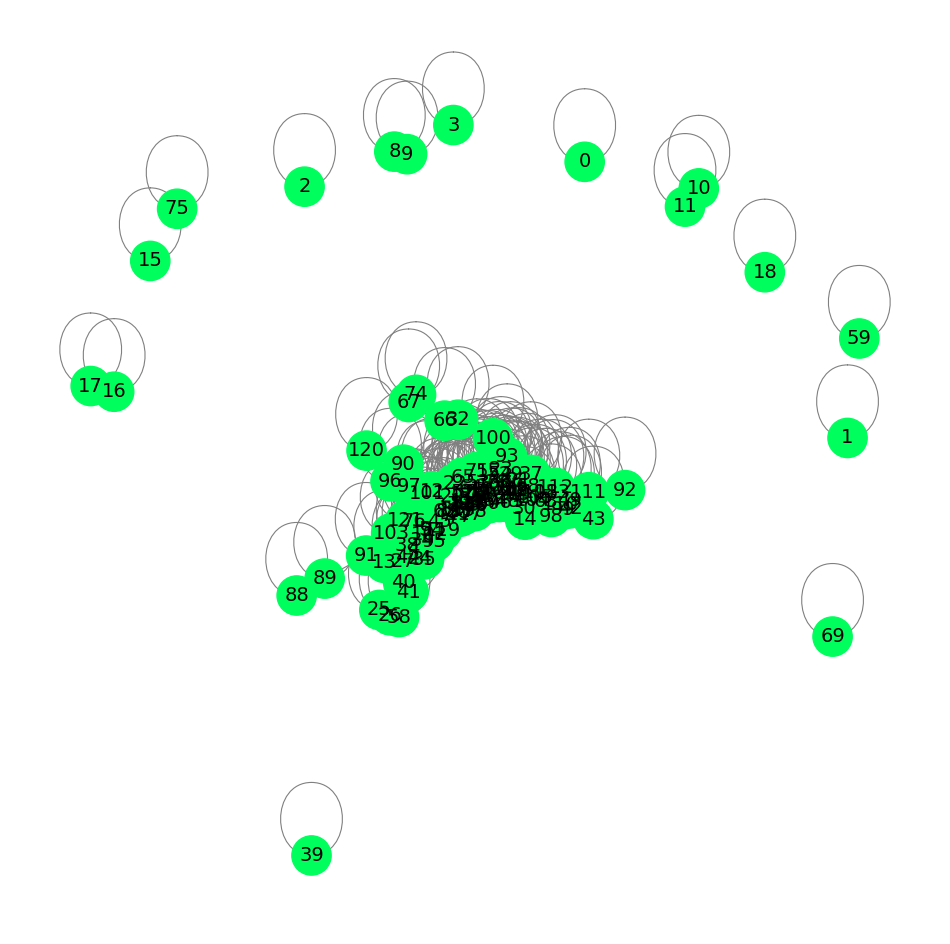

In [16]:
import networkx as nx
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')

node_colors = [data.y.item()] * data.num_nodes

nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=node_colors,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

# **Train-validation-test split**

In [17]:
from sklearn.model_selection import train_test_split

train_indices, temp_indices = train_test_split(range(len(dataset)), test_size=0.3, random_state=3)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=3)

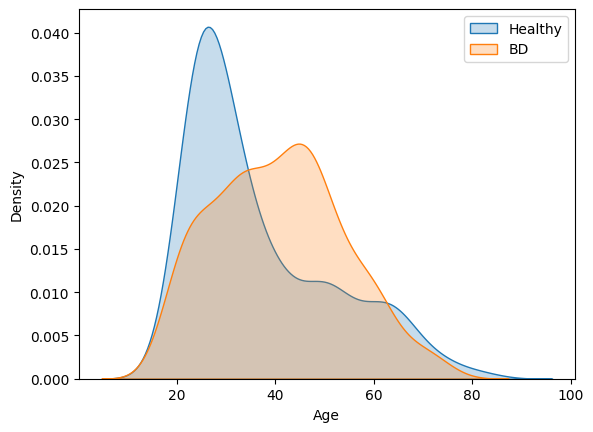

In [18]:
# Extract the training set covariates
# train_covars = strat_covars.iloc[train_indices]

# Filter by diagnosis
healthy_ages = strat_covars[strat_covars['Dx'] == 0]['Age']
bd_ages = strat_covars[strat_covars['Dx'] == 1]['Age']

# Create the plot
sns.kdeplot(healthy_ages, label='Healthy', fill=True)
sns.kdeplot(bd_ages, label='BD', fill=True)
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.savefig('age_distribution_pre.png', dpi = 300)
plt.show()

In [19]:
from scipy.stats import mannwhitneyu

age_diagnosis_0 = strat_covars[strat_covars['Dx'] == 0]['Age']
age_diagnosis_1 = strat_covars[strat_covars['Dx'] == 1]['Age']

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')

print(f"U-statistic: {u_stat}, P-value: {p_value}")

U-statistic: 120173.5, P-value: 2.9196695036136526e-09


In [20]:
import numpy as np

# Define drop fractions
drop_fraction_healthy = 0.3
drop_fraction_bd = 0.3

train_covars = strat_covars.iloc[train_indices]

# Identify subjects to drop
healthy_to_drop = train_covars[
    (train_covars['Dx'] == 0) &
    (train_covars['Age'] >= 15) &
    (train_covars['Age'] <= 30)
].sample(frac=drop_fraction_healthy, random_state=42)

bd_to_drop = train_covars[
    (train_covars['Dx'] == 1) &
    (train_covars['Age'] >= 40) &
    (train_covars['Age'] <= 60)
].sample(frac=drop_fraction_bd, random_state=42)


indices_to_remove = set(healthy_to_drop.index).union(set(bd_to_drop.index))

# Create the new train indices excluding these subjects
train_indices_new = [idx for idx in train_indices if idx not in indices_to_remove]


print(f"Removed {len(indices_to_remove)} subjects.")
print(f"New training set size: {len(train_indices_new)}")


Removed 109 subjects.
New training set size: 665


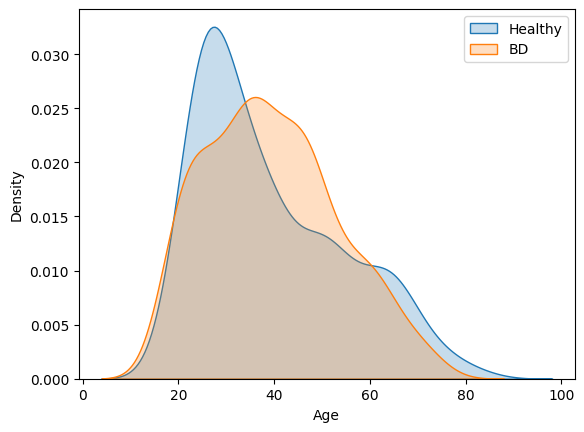

In [21]:
# Extract the training set covariates
train_covars_new = strat_covars.iloc[train_indices_new]

# Filter by diagnosis
healthy_ages = train_covars_new[train_covars_new['Dx'] == 0]['Age']
bd_ages = train_covars_new[train_covars_new['Dx'] == 1]['Age']

# Create the plot
sns.kdeplot(healthy_ages, label='Healthy', fill=True)
sns.kdeplot(bd_ages, label='BD', fill=True)
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.savefig('age_distribution_post.png', dpi = 300)
plt.show()

In [22]:
from scipy.stats import mannwhitneyu

age_diagnosis_0 = train_covars_new[train_covars_new['Dx'] == 0]['Age']
age_diagnosis_1 = train_covars_new[train_covars_new['Dx'] == 1]['Age']

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')

print(f"U-statistic: {u_stat}, P-value: {p_value}")

U-statistic: 52730.5, P-value: 0.37945085671835976


In [23]:
train_loader = DataLoader(dataset[train_indices_new], batch_size=32, shuffle=True)
val_loader = DataLoader(dataset[val_indices], batch_size=32, shuffle=False)
test_loader = DataLoader(dataset[test_indices], batch_size=32, shuffle=False)

In [24]:
counts = torch.bincount(train_loader.dataset.y)
print(counts)
print(counts[0]/sum(counts))
counts = torch.bincount(val_loader.dataset.y)
print(counts)
print(counts[0]/sum(counts))
counts = torch.bincount(test_loader.dataset.y)
print(counts)
print(counts[0]/sum(counts))


tensor([360, 305])
tensor(0.5414)
tensor([93, 73])
tensor(0.5602)
tensor([91, 75])
tensor(0.5482)


# **Graph Neural Networks**

In [26]:
#Graph Convolutional Network
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch import Tensor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from itertools import product

### GAT + BatchNorm and DropOut

In [ ]:
from torch_geometric.nn import GATConv, global_add_pool

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, heads=4, dropout=0.5):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        self.dropout = torch.nn.Dropout(dropout)

        # Input layer
        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout))
        self.bns.append(BatchNorm1d(hidden_channels * heads))  # Adjusted for multi-head output

        # Hidden layers
        for _ in range(num_layers - 1):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout))
            self.bns.append(BatchNorm1d(hidden_channels * heads))

        # Output layer (single head for classification)
        self.conv_out = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index, batch):
        batch_size = batch.max().item() + 1

        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index).relu()
            x = bn(x)  # Apply Batch Normalization
            x = self.dropout(x)  # Apply Dropout

        x = self.conv_out(x, edge_index)
        x = global_add_pool(x, batch, size=batch_size)

        return x

# Instantiate the model
model = GAT(dataset.num_features, 32, dataset.num_classes, num_layers=3)
print(model)


GAT(
  (convs): ModuleList(
    (0): GATConv(122, 32, heads=4)
    (1-2): 2 x GATConv(128, 32, heads=4)
  )
  (bns): ModuleList(
    (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (conv_out): GATConv(128, 2, heads=1)
)


### GIN + BatchNorm and DropOut

In [ ]:
from torch_geometric.nn import MLP, GINConv, global_add_pool
from torch.nn import BatchNorm1d

class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout=0.5):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        for _ in range(num_layers):
            mlp = MLP([in_channels, hidden_channels, hidden_channels])
            self.convs.append(GINConv(nn=mlp, train_eps=False))
            self.bns.append(BatchNorm1d(hidden_channels))
            in_channels = hidden_channels

        self.mlp = MLP([hidden_channels, hidden_channels, out_channels], norm=None, dropout=dropout)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, edge_index, batch):
        batch_size = batch.max().item() + 1

        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index).relu()
            x = bn(x)
            x = self.dropout(x)

        x = global_mean_pool(x, batch, size=batch_size)
        return self.mlp(x)

model = GIN(dataset.num_features, 16, dataset.num_classes, num_layers=2)
print(model)


GIN(
  (convs): ModuleList(
    (0): GINConv(nn=MLP(122, 16, 16))
    (1): GINConv(nn=MLP(16, 16, 16))
  )
  (bns): ModuleList(
    (0-1): 2 x BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp): MLP(16, 16, 2)
  (dropout): Dropout(p=0.5, inplace=False)
)


### GCN + Node Norm

In [27]:
import torch.nn as nn

class NodeNorm(nn.Module):
    def __init__(self, nn_type="n", unbiased=False, eps=1e-5, power_root=2):
        super(NodeNorm, self).__init__()
        self.unbiased = unbiased
        self.eps = eps
        self.nn_type = nn_type
        self.power = 1 / power_root

    def forward(self, x):
        if self.nn_type == "n":
            mean = torch.mean(x, dim=1, keepdim=True)
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = (x - mean) / std
        elif self.nn_type == "v":
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = x / std
        elif self.nn_type == "m":
            mean = torch.mean(x, dim=1, keepdim=True)
            x = x - mean
        elif self.nn_type == "srv":  # square root of variance
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = x / torch.sqrt(std)
        elif self.nn_type == "pr":
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = x / torch.pow(std, self.power)
        return x

    def __repr__(self):
        original_str = super().__repr__()
        components = list(original_str)
        nn_type_str = f"nn_type={self.nn_type}"
        components.insert(-1, nn_type_str)
        new_str = "".join(components)
        return new_str

def get_normalization(norm_type, num_channels=None):
    if norm_type is None:
        norm = None
    elif norm_type == "batch":
        norm = nn.BatchNorm1d(num_features=num_channels)
    elif norm_type == "node_n":
        norm = NodeNorm(nn_type="n")
    elif norm_type == "node_v":
        norm = NodeNorm(nn_type="v")
    elif norm_type == "node_m":
        norm = NodeNorm(nn_type="m")
    elif norm_type == "node_srv":
        norm = NodeNorm(nn_type="srv")
    elif norm_type.find("node_pr") != -1:
        power_root = norm_type.split("_")[-1]
        power_root = int(power_root)
        norm = NodeNorm(nn_type="pr", power_root=power_root)
    elif norm_type == "layer":
        norm = nn.LayerNorm(normalized_shape=num_channels)
    else:
        raise NotImplementedError
    return norm


In [28]:
from torch.nn import BatchNorm1d, Dropout

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, norm_type="node_n"):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(GCNConv(input_dim, hidden_dim))
        self.bns.append(get_normalization(norm_type=norm_type, num_channels=hidden_dim))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(get_normalization(norm_type=norm_type, num_channels=hidden_dim))

        self.fc = Linear(hidden_dim, output_dim)
        # self.dropout = Dropout(dropout_rate)

    def forward(self, x, edge_index, batch):

        for conv, bn in zip(self.convs, self.bns):
            x = F.relu(conv(x, edge_index))
            x = bn(x)
            # x = self.dropout(x)

        x = global_mean_pool(x, batch)

        x = self.fc(x)
        return x

### Train and test + Grid Search

In [29]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train():
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        all_preds.append(out.argmax(dim=1).cpu().numpy())
        all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average="weighted")
    train_loss = epoch_loss / len(train_loader)

    return accuracy, train_loss, f1

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            loss = F.cross_entropy(out, data.y)
            total_loss += loss.item()
            all_preds.append(out.argmax(dim=1).cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    # Calculate metrics
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average="weighted")
    val_loss = total_loss / len(loader)

    return accuracy, val_loss, f1, all_preds, all_labels

In [ ]:
num_layers_list = [2, 3, 4]
hidden_dims_list = [32, 64, 128]
norm_types_list = ["layer","node_n", "node_v", "node_m","node_srv","node_pr_2"] #
param_grid = list(product(num_layers_list, hidden_dims_list, norm_types_list))

best_val_acc = 0
best_params = None
best_model_path = "best_grid_model.pt"
results = []


for num_layers, hidden_dim, norm_type in param_grid:
    print(f"\nTraining with num_layers={num_layers}, hidden_dim={hidden_dim}, norm_type={norm_type}")

    set_seed(42)

    model = GCN(dataset.num_features, hidden_dim=hidden_dim, output_dim=dataset.num_classes, num_layers=num_layers, norm_type=norm_type)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    patience = 20
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(100):
        train_acc, train_loss, train_f1 = train()
        val_acc, val_loss, val_f1, _, _ = evaluate(val_loader)

        print(
            f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "temp_model.pt")  # Save the best model for this config
            print(f"Saved best model at epoch {epoch} with Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Load best model for this configuration
    model.load_state_dict(torch.load("temp_model.pt"))
    test_acc, test_loss, test_f1,_,_ = evaluate(test_loader)
    results.append({
                "num_layers": num_layers,
                "hidden_dim": hidden_dim,
                "norm_type": norm_type,
                "test_accuracy": test_acc,
                "test_loss": test_loss,
                "test_f1": test_f1
            })

    print(f"For num_layers={num_layers}, hidden_dim={hidden_dim}: Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")

    # Update best model if current one is better
    if test_acc > best_val_acc:
        best_val_acc = test_acc
        best_params = (num_layers, hidden_dim, norm_type)
        torch.save(model.state_dict(), best_model_path)  # Save the best model

# Final results
print(f"\nBest Model: num_layers={best_params[0]}, hidden_dim={best_params[1]},  norm_type={best_params[2]} with Accuracy={best_val_acc:.4f}")
df_results = pd.DataFrame(results)
df_results_correct = df_results['test_accuracy'].round(4)*100
df_results_correct

# GNNs with edge attributes

### GCN + Node Norm

In [31]:
import torch.nn as nn

class NodeNorm(nn.Module):
    def __init__(self, nn_type="n", unbiased=False, eps=1e-5, power_root=2):
        super(NodeNorm, self).__init__()
        self.unbiased = unbiased
        self.eps = eps
        self.nn_type = nn_type
        self.power = 1 / power_root

    def forward(self, x):
        if self.nn_type == "n":
            mean = torch.mean(x, dim=1, keepdim=True)
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = (x - mean) / std
        elif self.nn_type == "v":
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = x / std
        elif self.nn_type == "m":
            mean = torch.mean(x, dim=1, keepdim=True)
            x = x - mean
        elif self.nn_type == "srv":  # square root of variance
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = x / torch.sqrt(std)
        elif self.nn_type == "pr":
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = x / torch.pow(std, self.power)
        return x

    def __repr__(self):
        original_str = super().__repr__()
        components = list(original_str)
        nn_type_str = f"nn_type={self.nn_type}"
        components.insert(-1, nn_type_str)
        new_str = "".join(components)
        return new_str

def get_normalization(norm_type, num_channels=None):
    if norm_type is None:
        norm = None
    elif norm_type == "batch":
        norm = nn.BatchNorm1d(num_features=num_channels)
    elif norm_type == "node_n":
        norm = NodeNorm(nn_type="n")
    elif norm_type == "node_v":
        norm = NodeNorm(nn_type="v")
    elif norm_type == "node_m":
        norm = NodeNorm(nn_type="m")
    elif norm_type == "node_srv":
        norm = NodeNorm(nn_type="srv")
    elif norm_type.find("node_pr") != -1:
        power_root = norm_type.split("_")[-1]
        power_root = int(power_root)
        norm = NodeNorm(nn_type="pr", power_root=power_root)
    elif norm_type == "layer":
        norm = nn.LayerNorm(normalized_shape=num_channels)
    else:
        raise NotImplementedError
    return norm


In [32]:
from torch.nn import BatchNorm1d, Dropout

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, norm_type="node_n"):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(GCNConv(input_dim, hidden_dim))
        self.bns.append(get_normalization(norm_type=norm_type, num_channels=hidden_dim))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(get_normalization(norm_type=norm_type, num_channels=hidden_dim))

        self.fc = Linear(hidden_dim, output_dim)
        # self.dropout = Dropout(dropout_rate)

    def forward(self, x, edge_index, edge_attr, batch):

        for conv, bn in zip(self.convs, self.bns):
            x = F.relu(conv(x, edge_index, edge_attr))
            x = bn(x)
            # x = self.dropout(x)

        x = global_mean_pool(x, batch)

        x = self.fc(x)
        return x

### Train and test + Grid Search

In [33]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train():
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        all_preds.append(out.argmax(dim=1).cpu().numpy())
        all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average="weighted")
    train_loss = epoch_loss / len(train_loader)

    return accuracy, train_loss, f1

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = F.cross_entropy(out, data.y)
            total_loss += loss.item()
            all_preds.append(out.argmax(dim=1).cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    # Calculate metrics
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average="weighted")
    val_loss = total_loss / len(loader)

    return accuracy, val_loss, f1, all_preds, all_labels

In [ ]:

num_layers_list = [2, 3, 4]
hidden_dims_list = [32, 64, 128]
norm_types_list = ["layer", "node_n", "node_v", "node_m","node_srv","node_pr_2"] #
param_grid = list(product(num_layers_list, hidden_dims_list, norm_types_list))

best_val_acc = 0
best_params = None
best_model_path = "best_grid_model_1.pt"
results = []


for num_layers, hidden_dim, norm_type in param_grid:
    print(f"\nTraining with num_layers={num_layers}, hidden_dim={hidden_dim}, norm_type={norm_type}")

    set_seed(42)

    model = GCN(dataset.num_features, hidden_dim=hidden_dim, output_dim=dataset.num_classes, num_layers=num_layers, norm_type=norm_type)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    patience = 20
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(100):
        train_acc, train_loss, train_f1 = train()
        val_acc, val_loss, val_f1, _, _ = evaluate(val_loader)

        print(
            f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "temp_model_1.pt")  # Save the best model for this config
            print(f"Saved best model at epoch {epoch} with Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Load best model for this configuration
    model.load_state_dict(torch.load("temp_model_1.pt"))
    test_acc, test_loss, test_f1,_,_ = evaluate(test_loader)

    print(f"For num_layers={num_layers}, hidden_dim={hidden_dim}, norm_type={norm_type}: Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")
    results.append({
                "num_layers": num_layers,
                "hidden_dim": hidden_dim,
                "norm_type": norm_type,
                "test_accuracy": test_acc,
                "test_loss": test_loss,
                "test_f1": test_f1
            })
    # Update best model if current one is better
    if test_acc > best_val_acc:
        best_val_acc = test_acc
        best_params = (num_layers, hidden_dim, norm_type)
        torch.save(model.state_dict(), best_model_path)  # Save the best model

# Final results
print(f"\nBest Model: num_layers={best_params[0]}, hidden_dim={best_params[1]},  norm_type={best_params[2]} with Accuracy={best_val_acc:.4f}")
df_results = pd.DataFrame(results)
df_results_correct = df_results['test_accuracy'].round(4)*100
df_results_correct
